# tracker_comparison
Written by [Eliot Quon](mailto:eliot.quon@nrel.gov) -- 2017-01-04

Instantaneous snapshot provided by [Paula Doubrawa](mailto:paula.doubrawa@nrel.gov)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from samwich.dataloaders import planar_data
from samwich.waketrackers import track

In [2]:
trackerlist = track()

Need to specify 'method' as one of:
  ConstantArea (samwich.contour.ConstantAreaTracker)
  ConstantFlux (samwich.contour.ConstantFluxTracker)
  Gaussian2D (samwich.gaussian.Gaussian2DTracker)
  Gaussian (samwich.gaussian.GaussianTracker)
  CircularTestRegion (samwich.testregion.CircularTestRegionTracker)


## Case-specific parameters

In [3]:
D = 27.0  # to define the search range, and the reference area for the contour methods
zhub = 32.1  # hub height [m], for estimating the freestream reference velocity
aref = 0.3  # induction, for estimating the momentum theory mass/momentum flux

In [4]:
ref_area = np.pi*D**2/4
print(ref_area)

572.5552611167398


In [5]:
ref_CT = 4*aref*(1-aref)  # thrust coefficient
ref_CP = 4*aref*(1-aref)**2  # power coefficient
print(ref_CT,ref_CP)

0.84 0.5879999999999999


In [6]:
styles = {
    'gaussian (R)': {
        'label':r'1-D Gaussian ($\sigma=R$)',
        'color':'b',
        'linestyle':'--','linewidth':2,
        'marker':'o','markersize':6
    },
    'gaussian (1.5R)': {
        'label':r'1-D Gaussian ($\sigma=1.5R$)',
        'color':'m',
        'linestyle':'--','linewidth':2,
        'marker':'o','markersize':6
    },
    'gaussian (ideal)': {
        'label':r'1-D Gaussian (momentum deficit $\sigma$)',
        'color':'r',
        'linestyle':'--','linewidth':2,
        'marker':'o','markersize':6
    },
    'elliptical': {
        'label':r'2-D Gaussian (opt $\sigma_x$,$\sigma_y$,$\theta$)',
        'color':'y',
        'linestyle':'--','linewidth':2,
        'marker':'o','markersize':6
    },
    
    'const area': {
        'label':r'const area contour',
        'color':'b',
        'linestyle':'-','linewidth':2,
        'marker':'+','markersize':10
    },
    'momentum deficit': {
        'label':r'const x-mom deficit contour',
        'color':'r',
        'linestyle':'-','linewidth':2,
        'marker':'+','markersize':10
    },
    
    'min power': {
        'label':r'min power region',
        'color':'0.6',
        'linestyle':'-','linewidth':2,
        'marker':'x','markersize':8
    },
}

## Read in test data
Note: General dataloaders exist to handle processing of multiple sampling locations and/or many samples over time.

In [7]:
sample = {}
#kind = 'mean'  # sanity check, not very interesting
kind = 'instantaneous'
varlist = ['x','y','z','u','v','w']
sample = planar_data({v: np.loadtxt(f'MWE-data/3D_{kind}_{v}_WFoR.txt') for v in varlist})

## Calculate freestream
Note: This is an optional step if upstream data are available.

ref velocity (at z=32.1667) is 6.669858550736894


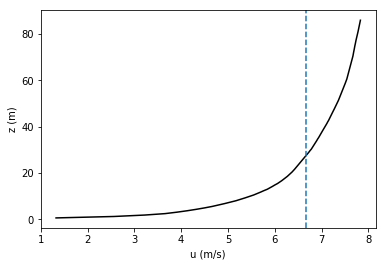

In [8]:
data = {v: np.loadtxt(f'MWE-data/freestream_mean_{v}_WFoR.txt') for v in varlist}
free_z = data['z'][0,:]
free_Uprofile = np.mean(data['u'],axis=0)
jhub = np.argmin(np.abs(data['y'][:,0]-np.mean(data['y'][:,0])))
khub = np.argmin(np.abs(data['z'][0,:]-zhub))
ref_velocity = data['u'][jhub,khub]
#free_const = free_Uprofile*0.0 + ref_velocity

fig,ax = plt.subplots()
ax.plot(free_Uprofile,free_z,'-k')
ax.axvline(ref_velocity,linestyle='--')
plt.xlabel('u (m/s)')
plt.ylabel('z (m)')

print(f"ref velocity (at z={data['z'][0,khub]}) is {ref_velocity}")

In [9]:
ref_thrust = ref_CT * 0.5*ref_velocity**2 * ref_area  # force / density
print('ref thrust (momentum deficit) is',ref_thrust)

ref thrust (momentum deficit) is 10697.9348256


## <font color='grey'>*Create all wake tracking objects at once*</font>

In [10]:
#
# CLEANER/CLEARER TO JUST CREATE THE TRACKER WITH EACH CASE
#
#for tracker in trackerlist:
#    wake[tracker] = track(sample.sliceI(),method=tracker,verbose=True) 
#    wake[tracker].remove_shear(wind_profile=free_Uprofile)

In [11]:
wake = {}
yc,zc = {},{}

## Constant area contours

In [12]:
tracker = 'const area'
wake[tracker] = track(sample.sliceI(),method='ConstantArea',verbose=True) 
wake[tracker].remove_shear(wind_profile=free_Uprofile)
yc[tracker],zc[tracker] = wake[tracker].find_centers(ref_area,
                                                     tol=0.01,  # min spacing to test (default:0.01)
                                                     verbosity=0,  # >0 for debugging
                                                    )  # center is weighted by velocity deficit by default

Slicing data at i=0 x=2495.7991314383826
Selected Tracker: ConstantArea

Sampling plane normal vector: [ 1.  0.  0.]
  identified plane center at: 2495.7991314383817 0.001703044636769846 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96262213050795 58.96262213050795
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing waketracker

...finished initializing contourwaketracker

...finished initializing ConstantArea 

  subtracting out constant profile
Attempting to match area: 572.5552611167398 m^2


Processed frame 0


## Momentum deficit contours

In [13]:
tracker = 'momentum deficit'
func = lambda u: u*(ref_velocity-u)
wake[tracker] = track(sample.sliceI(),method='ConstantFlux',verbose=True) 
wake[tracker].remove_shear(wind_profile=free_Uprofile)
yc[tracker],zc[tracker] = wake[tracker].find_centers(ref_thrust,
                                                     flux_function=func,
                                                     flux_field='u_tot',  # instantaneous velocity
                                                     tol=0.01,  # min spacing to test (default:0.01)
                                                     verbosity=0,  # >0 for debugging
                                                    )  # center is weighted by velocity deficit by default

Slicing data at i=0 x=2495.7991314383826
Selected Tracker: ConstantFlux

Sampling plane normal vector: [ 1.  0.  0.]
  identified plane center at: 2495.7991314383817 0.001703044636769846 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96262213050795 58.96262213050795
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing waketracker

...finished initializing contourwaketracker

...finished initializing ConstantFlux 

  subtracting out constant profile
Sample function evaluation: f(u=0.38453) = 2.4169
Attempting to match integral: 10697.9348256


Processed frame 0


## Gaussian Fits

In [14]:
tracker = 'gaussian (R)'
wake[tracker] = track(sample.sliceI(),method='Gaussian',verbose=True) 
wake[tracker].remove_shear(wind_profile=free_Uprofile)
yc[tracker],zc[tracker] = wake[tracker].find_centers(umin=None,  # detected from wake snapshot
                                                     sigma=D/2,
                                                    )  # center is weighted by velocity deficit by default

Slicing data at i=0 x=2495.7991314383826
Selected Tracker: Gaussian

Sampling plane normal vector: [ 1.  0.  0.]
  identified plane center at: 2495.7991314383817 0.001703044636769846 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96262213050795 58.96262213050795
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing waketracker

...finished initializing Gaussian 

  subtracting out constant profile
Calculated umin= [-4.86021908]
Average Gaussian function amplitude = -4.86021908318 m/s (over all times)
Specified Gaussian width = 13.5 m


Processed frame 0


In [15]:
tracker = 'gaussian (1.5R)'
wake[tracker] = track(sample.sliceI(),method='Gaussian',verbose=True) 
wake[tracker].remove_shear(wind_profile=free_Uprofile)
yc[tracker],zc[tracker] = wake[tracker].find_centers(umin=None,  # detected from wake snapshot
                                                     sigma=0.75*D,
                                                    )  # center is weighted by velocity deficit by default

Slicing data at i=0 x=2495.7991314383826
Selected Tracker: Gaussian

Sampling plane normal vector: [ 1.  0.  0.]
  identified plane center at: 2495.7991314383817 0.001703044636769846 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96262213050795 58.96262213050795
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing waketracker

...finished initializing Gaussian 

  subtracting out constant profile
Calculated umin= [-4.86021908]
Average Gaussian function amplitude = -4.86021908318 m/s (over all times)
Specified Gaussian width = 20.25 m


Processed frame 0


### 2D Gaussian

In [16]:
tracker = 'elliptical'
wake[tracker] = track(sample.sliceI(),method='Gaussian2D',verbose=True) 
wake[tracker].remove_shear(wind_profile=free_Uprofile)
yc[tracker],zc[tracker] = wake[tracker].find_centers(umin=None, # detected from wake snapshot
                                                     A_min=ref_area/5.0, # ad hoc value
                                                     A_max=ref_area*2.0, # ad hoc value
                                                     AR_max=10.0, # ad hoc value
                                                    )  # center is weighted by velocity deficit by default

Slicing data at i=0 x=2495.7991314383826
Selected Tracker: Gaussian2D

Sampling plane normal vector: [ 1.  0.  0.]
  identified plane center at: 2495.7991314383817 0.001703044636769846 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96262213050795 58.96262213050795
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing waketracker

...finished initializing Gaussian2D 

  subtracting out constant profile
average Gaussian function amplitude = -4.86021908318 m/s


Processed frame 0


## Test Region Approach

In [17]:
tracker = 'min power'
wake[tracker] = track(sample.sliceI(),method='CircularTestRegion',verbose=True) 
wake[tracker].remove_shear(wind_profile=free_Uprofile)
yc[tracker],zc[tracker] = wake[tracker].find_centers(test_radius=D/2,  # following Vollmer 2016
                                                     test_function=lambda u: u**3,
                                                     test_field='u_tot',
                                                     verbosity=2,  # verbosity > 0 for debug output
                                                    )  # center is weighted by velocity deficit by default

Slicing data at i=0 x=2495.7991314383826
Selected Tracker: CircularTestRegion

Sampling plane normal vector: [ 1.  0.  0.]
  identified plane center at: 2495.7991314383817 0.001703044636769846 43.300985499999996
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -58.96262213050795 58.96262213050795
  vertical search range: 0.619571 85.9824
Number of time frames to process: 1

...finished initializing waketracker

...finished initializing CircularTestRegion 

  subtracting out constant profile
Searching within a region with radius=13.5
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6446e+10                                    6.41e+10    
       1              2         3.2146e+09      1.32e+10       1.04e+01       9.84e+09    
       2              3         2.3392e+09      8.75e+08       1.26e+01       1.21e+10    
       3              4         1.7209e+09    

Processed frame 0


## Comparisons

In [18]:
itime = 0

In [19]:
for tracker,wakeobj in wake.items():
    print(tracker,'center at',(yc[tracker][itime],zc[tracker][itime]))

const area center at (-20.417834403054869, 38.401603822625233)
momentum deficit center at (-16.696608141031533, 36.203693477517284)
gaussian (R) center at (-17.571701367409343, 35.671083051326406)
gaussian (1.5R) center at (-18.878044351113871, 30.691512603065632)
elliptical center at (-18.722361889401395, 37.902806104185522)
min power center at (-20.691627581756233, 37.356961566387803)


Plotting const area
Plotting momentum deficit
Plotting gaussian (R)
Plotting gaussian (1.5R)
Plotting elliptical
Plotting min power


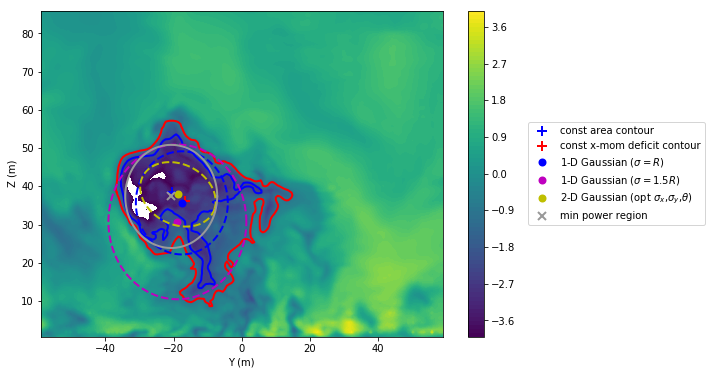

In [20]:
c1,c2,dc = -4, 4, 0.1 # for freestream profile

fig,ax = plt.subplots(figsize=(9,6))
p1 = ax.contourf(wake['const area'].xh[:,:],
                 wake['const area'].xv[:,:],
                 wake['const area'].u[0,:,:],levels=np.arange(c1,c2+dc,dc))
plt.colorbar(p1)
ax.set_xlabel('Y (m)')
ax.set_ylabel('Z (m)')

for tracker,wakeobj in wake.items():
    print('Plotting',tracker)
    
    ax.plot(yc[tracker][itime], zc[tracker][itime],
            color=styles[tracker]['color'],
            marker=styles[tracker]['marker'],linestyle='',
            ms=styles[tracker]['markersize'],mew=2,
            label=styles[tracker]['label'])
    ax.plot(wakeobj.paths[itime][:,0], wakeobj.paths[itime][:,1],
            color=styles[tracker]['color'],
            linestyle=styles[tracker]['linestyle'],
            linewidth=styles[tracker]['linewidth'])
    
legend = ax.legend(loc='center left',bbox_to_anchor=(1.2,0.5),ncol=1)
plt.savefig(f'detected_{kind}_wakes.png', dpi=150,
            bbox_extra_artists=(legend,), bbox_inches='tight')  # to handle outside legend

In [21]:
all_yc = [ yc[tracker][itime] for tracker in wake.keys() ]
all_zc = [ zc[tracker][itime] for tracker in wake.keys() ]
yc_range = np.max(all_yc) - np.min(all_yc)
zc_range = np.max(all_zc) - np.min(all_zc)
print(f'Range of yc : {yc_range} (=={yc_range/D:.3f}D)')
print(f'Range of zc : {zc_range} (=={zc_range/D:.3f}D)')

Range of yc : 3.9950194407247004 (==0.148D)
Range of zc : 7.710091219559601 (==0.286D)
